In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# [1]데이터 불러오기
- pykrx(네이버에서 금융 데이터 스크랩해주는 모듈) 사용

In [3]:
from pykrx import stock
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
 
    
# ticker와 list로 코스피 기업목록 가져오기
    
def return_name(market):
    Market = []
 
    for ticker in market:
        Value =stock.get_market_ticker_name(ticker)
        Market.append([Value,ticker])
 
    df = pd.DataFrame(Market,columns=['회사명','상장번호'])
    return df

In [4]:
KOSPI = stock.get_market_ticker_list(market="KOSPI")
db1 = return_name(KOSPI)

In [5]:
db1  # KOSPI

,회사명,상장번호
0,AJ네트웍스,095570
1,AK홀딩스,006840
2,BGF,027410
3,BGF리테일,282330
4,BNK금융지주,138930
...,...,...
917,휴켐스,069260
918,흥국화재,000540
919,흥국화재2우B,000547
920,흥국화재우,000545


In [6]:
db1[db1['회사명'] == '삼성전자']

,회사명,상장번호
413,삼성전자,005930


In [29]:
df = stock.get_market_ohlcv_by_date("20160104", "20210423", "005930")
df # 삼성주가 출력해보기

,시가,고가,저가,종가,거래량
날짜,,,,,
2016-01-04,25200,25200,24100,24100,306939
2016-01-05,24040,24360,23720,24160,216002
2016-01-06,24160,24160,23360,23500,366752
2016-01-07,23320,23660,23020,23260,282388
2016-01-08,23260,23720,23260,23420,257763
...,...,...,...,...,...
2021-04-19,83800,84000,83300,83300,15287311
2021-04-20,83300,84000,83100,83900,15521965
2021-04-21,83300,83500,82500,82600,21636079


In [8]:
kospi = return_name(KOSPI)
kospi.to_csv("kospi_list.csv")   # 코스피리스트 저장   # 코스피리스트 저장

In [30]:
# 시가총액 4대 기업 주식정보가져오기

stocks=['삼성전자','SK하이닉스','NAVER','LG화학']
df_res = pd.DataFrame()

for i in stocks:
    bun=db1[db1['회사명']==i]
    번호=bun.iloc[0,1]
    df_res[i] = stock.get_market_ohlcv_by_date("20160104", "20210325", 번호)['종가']

In [31]:
df_res    # 네이버 2018년 10월 액면분할

,삼성전자,SK하이닉스,NAVER,LG화학
날짜,,,,
2016-01-04,24100,30150,126579,341500
2016-01-05,24160,30600,127580,339500
2016-01-06,23500,30750,124776,338000
2016-01-07,23260,30200,130585,323000
2016-01-08,23420,29700,130585,330000
...,...,...,...,...
2021-03-19,81900,138000,402000,830000
2021-03-22,82000,138000,396500,805000
2021-03-23,81800,135000,386000,775000


In [32]:
# [2]효율적 투자선 구하기
## 1)기초개념

In [33]:
daily_ret = df_res.pct_change()           #pct_change() 일간 수익률 구하기
annual_ret = daily_ret.mean() * 252       #일간수익률 평균에 252를 곱해서 연간 수익률 구하기

daily_cov = daily_ret.cov()               #일간 리스크
annual_cov = daily_cov * 252              #연간 리스크

In [34]:
annual_ret

삼성전자      0.275629
SK하이닉스    0.358762
NAVER     0.272101
LG화학      0.238111
dtype: float64

In [35]:
annual_cov   # 각각의 분산표시 ~ 리스크의 제곱값 ~ variance-covariance matrix

,삼성전자,SK하이닉스,NAVER,LG화학
삼성전자,0.073652,0.061112,0.024163,0.035629
SK하이닉스,0.061112,0.134411,0.026022,0.039573
NAVER,0.024163,0.026022,0.112890,0.031803
LG화학,0.035629,0.039573,0.031803,0.148128


In [36]:
 np.random.random(4)   # 0~1사이 값 난수생성

array([0.00113788, 0.31656166, 0.05360087, 0.86802569])

In [37]:
# 포트폴리오 비중 구하기
weights = np.random.random(len(stocks)) 
weights /= np.sum(weights)        # 총합으로 나누어 난수들 합이 1이 되도록 조정
weights                                

array([0.32844722, 0.07702975, 0.32513846, 0.26938457])

## 2)몬테카를로 시뮬레이션
- 많은 난수를 통해 함수의 값을 확률적으로 계산

In [38]:
port_ret = []       # 포트폴리오 수익률
port_risk = []      # 포트폴리오 리스크
port_weights = []   # 종목 비중
sharpe_ratio = []   # 샤프비율 리스트 설정

for _ in range(20000):                         # 20000개의 포트폴리오 생성
    
    weights = np.random.random(len(stocks))    # 4가지 종목 난수생성
    weights /= np.sum(weights)                 # weights의 총합으로 나누어 총합 1이되게 조정

    returns = np.dot(weights, annual_ret)      #각 종목 비중과 수익률을 곱해 해당 포트폴리오의 수익률 계산
    risk = np.sqrt(np.dot(weights.T, np.dot(annual_cov, weights)))    #해당 포트폴리오 리스크 계산

    port_ret.append(returns)                    # 각 리스트에 append
    port_risk.append(risk) 
    port_weights.append(weights) 
    sharpe_ratio.append(returns/risk)           # 샤프지수 append

portfolio = {'Returns': port_ret, 'Risk': port_risk, 'Sharpe' : sharpe_ratio}     # portfolio 딕셔너리에 각 종목별로 비중값 추가

for i, s in enumerate(stocks): 
    portfolio[s] = [weight[i] for weight in port_weights] 
    
df = pd.DataFrame(portfolio) 
df = df[['Returns', 'Risk','Sharpe'] + [s for s in stocks]] 

In [39]:
for i,s in enumerate(stocks):
    print('i값:',i)
    print('s값:',s)

i값: 0
s값: 삼성전자
i값: 1
s값: SK하이닉스
i값: 2
s값: NAVER
i값: 3
s값: LG화학


In [40]:
df

,Returns,Risk,Sharpe,삼성전자,SK하이닉스,NAVER,LG화학
0,0.269082,0.251792,1.068668,0.130470,0.073062,0.507818,0.288651
1,0.298698,0.242904,1.229698,0.200572,0.343214,0.342842,0.113372
2,0.285142,0.243382,1.171581,0.153442,0.205763,0.483920,0.156875
3,0.304916,0.250631,1.216593,0.157358,0.396544,0.384147,0.061950
4,0.310820,0.269398,1.153758,0.096656,0.530542,0.149217,0.223585
...,...,...,...,...,...,...,...
19995,0.287291,0.240408,1.195014,0.151546,0.253768,0.378845,0.215841
19996,0.308302,0.262355,1.175132,0.023246,0.497343,0.274017,0.205394
19997,0.277341,0.243249,1.140156,0.523556,0.142503,0.070443,0.263498
19998,0.313878,0.278710,1.126183,0.103377,0.570074,0.091463,0.235087


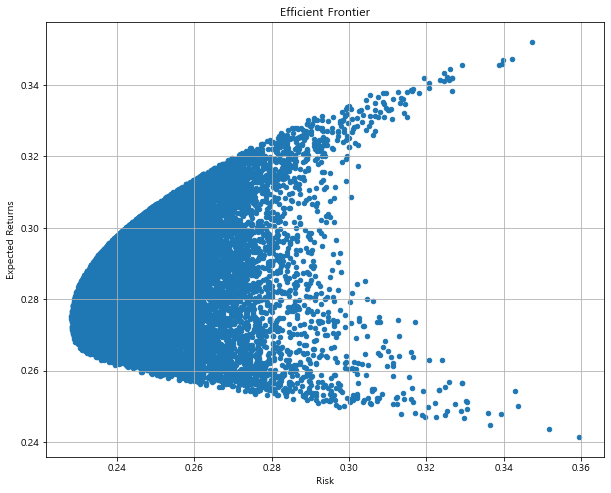

In [49]:
# 효율적 투자선 그리기
df.plot.scatter(x='Risk', y='Returns', figsize=(10, 8), grid=True)
plt.title('Efficient Frontier') 
plt.xlabel('Risk') 
plt.ylabel('Expected Returns') 

plt.show() 

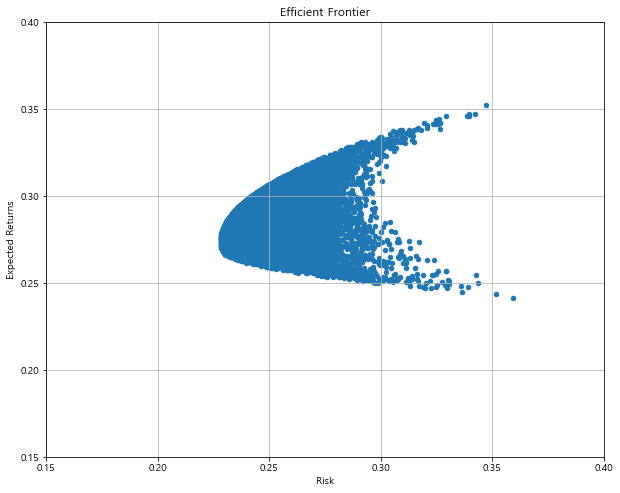

In [56]:
df.plot.scatter(x='Risk', y='Returns', figsize=(10, 8), grid=True)
plt.title('Efficient Frontier') 
plt.xlabel('Risk') 
plt.ylabel('Expected Returns') 

plt.xlim([0.15,0.4])
plt.ylim([0.15,0.4])
plt.show() 

## [3] 샤프지수, 효율적 투자선

In [50]:
# Mean-Varinance portfolio(평균분산포트폴리오) : 최대 샤프지수 ~ 탄젠트
max_sharpe = df.loc[df['Sharpe'] ==df['Sharpe'].max()]
max_sharpe

,Returns,Risk,Sharpe,삼성전자,SK하이닉스,NAVER,LG화학
6951,0.292476,0.235409,1.242417,0.35239,0.255924,0.302046,0.08964


In [51]:
# Mininum-Variance portfolio(최소분산포트폴리오) : 최소 Variance(=Risk)
min_risk = df.loc[df['Risk'] == df['Risk'].min()]
min_risk

,Returns,Risk,Sharpe,삼성전자,SK하이닉스,NAVER,LG화학
18726,0.275037,0.22827,1.204877,0.478553,0.073034,0.298904,0.149509


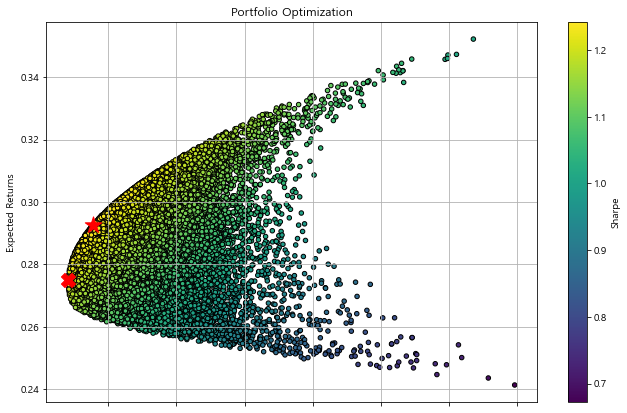

In [52]:
# minimum-variance portfolio와 mean-variance portfolio 시각화

df.plot.scatter(x='Risk', y='Returns', c='Sharpe', cmap='viridis',
    edgecolors='k', figsize=(11,7), grid=True)   

plt.scatter(x=max_sharpe['Risk'], y=max_sharpe['Returns'], c='r',      # 평균분산포트폴리오 *표시
    marker='*', s=300)  

plt.scatter(x=min_risk['Risk'], y=min_risk['Returns'], c='r',          # 최소분산포트폴리오 X표시
    marker='X', s=200)  

plt.title('Portfolio Optimization') 
plt.xlabel('Risk') 
plt.ylabel('Expected Returns') 
plt.show()